## World Happiness Report 2019

### Import Modules

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from pprint import pprint
from scipy import stats
import psycopg2
from sqlalchemy import create_engine
import psycopg2.extras as extras
import io

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, auc
from xgboost import XGBClassifier

### Import data from the World Happiness Report via Kaggle https://www.kaggle.com/unsdsn/world-happiness/code

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_to_load = (r'C:\Users\watso\Documents\Data_Science_Bootcamp\WorldHappinessReport\2019.csv')


whr_2019_data = pd.read_csv(file_to_load)
whr_2019_df = pd.DataFrame(whr_2019_data)
display(whr_2019_df)

Overall rank         Country or region  Score  GDP per capita  \
0               1                   Finland  7.769           1.340   
1               2                   Denmark  7.600           1.383   
2               3                    Norway  7.554           1.488   
3               4                   Iceland  7.494           1.380   
4               5               Netherlands  7.488           1.396   
..            ...                       ...    ...             ...   
151           152                    Rwanda  3.334           0.359   
152           153                  Tanzania  3.231           0.476   
153           154               Afghanistan  3.203           0.350   
154           155  Central African Republic  3.083           0.026   
155           156               South Sudan  2.853           0.306   

     Social support  Healthy life expectancy  Freedom to make life choices  \
0             1.587                    0.986                         0.596   
1             1.573                    0.996                         0.592   
2             1.582                    1.028                         0.603   
3             1.624                    1.026                         0.591   
4             1.522                    0.999                         0.557   
..              ...                      ...                           ...   
151           0.711                    0.614                         0.555   
152           0.885                    0.499                         0.417   
153           0.517                    0.361                         0.000   
154           0.000                    0.105                         0.225   
155           0.575                    0.295                         0.010   

     Generosity  Perceptions of corruption  
0         0.153                      0.393  
1         0.252                      0.410  
2         0.271                      0.341  
3         0.354                      0.118  
4         0.322                      0.298  
..          ...                        ...  
151       0.217                      0.411  
152       0.276                      0.147  
153       0.158                      0.025  
154       0.235                      0.035  
155       0.202                      0.091  

[156 rows x 9 columns]

### Check for nulls

In [28]:
whr_2019_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


### Preprocessing Steps not required - null values are not present and there are no large outliers or categorical data

### Exploring Correlation

The three factors most highly correlated with score are GDP pre capita, social support, and healthy life expectancy

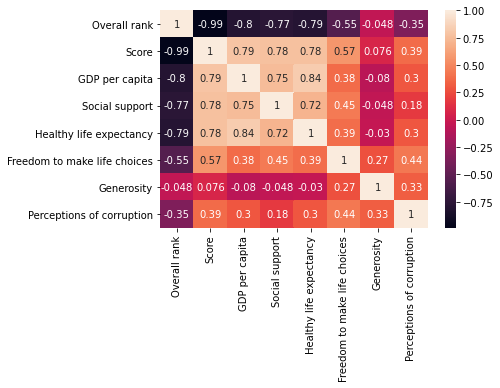

In [29]:
import seaborn as sn

corrMatrix = whr_2019_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### Exploring the top ten scorers

In [30]:
top_ten = whr_2019_df.head(10)
top_ten

Overall rank Country or region  Score  GDP per capita  Social support  \
0             1           Finland  7.769           1.340           1.587   
1             2           Denmark  7.600           1.383           1.573   
2             3            Norway  7.554           1.488           1.582   
3             4           Iceland  7.494           1.380           1.624   
4             5       Netherlands  7.488           1.396           1.522   
5             6       Switzerland  7.480           1.452           1.526   
6             7            Sweden  7.343           1.387           1.487   
7             8       New Zealand  7.307           1.303           1.557   
8             9            Canada  7.278           1.365           1.505   
9            10           Austria  7.246           1.376           1.475   

   Healthy life expectancy  Freedom to make life choices  Generosity  \
0                    0.986                         0.596       0.153   
1                    0.996                         0.592       0.252   
2                    1.028                         0.603       0.271   
3                    1.026                         0.591       0.354   
4                    0.999                         0.557       0.322   
5                    1.052                         0.572       0.263   
6                    1.009                         0.574       0.267   
7                    1.026                         0.585       0.330   
8                    1.039                         0.584       0.285   
9                    1.016                         0.532       0.244   

   Perceptions of corruption  
0                      0.393  
1                      0.410  
2                      0.341  
3                      0.118  
4                      0.298  
5                      0.343  
6                      0.373  
7                      0.380  
8                      0.308  
9                      0.226

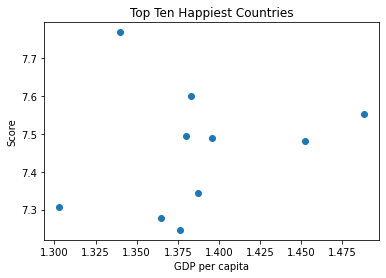

In [31]:
X = top_ten['GDP per capita']
Y = top_ten['Score']
plt.scatter(X, Y)
plt.xlabel("GDP per capita")
plt.ylabel("Score")
plt.title("Top Ten Happiest Countries")
plt.show()

### Visualizing scores vs individual factors

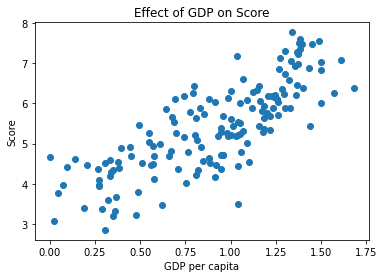

In [32]:
X = whr_2019_df['GDP per capita']
Y = whr_2019_df['Score']
plt.scatter(X, Y)
plt.xlabel("GDP per capita")
plt.ylabel("Score")
plt.title("Effect of GDP on Score")
plt.show()

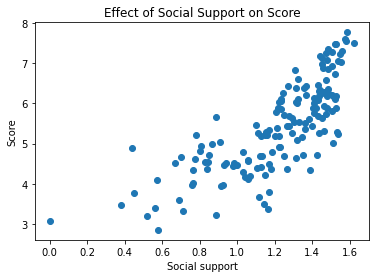

In [33]:
X = whr_2019_df['Social support']
Y = whr_2019_df['Score']
plt.scatter(X, Y)
plt.xlabel("Social support")
plt.ylabel("Score")
plt.title("Effect of Social Support on Score")
plt.show()

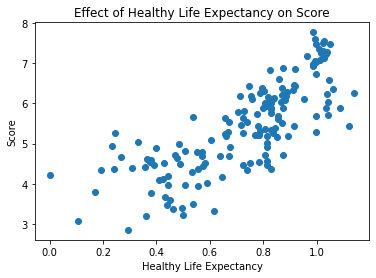

In [34]:
X = whr_2019_df['Healthy life expectancy']
Y = whr_2019_df['Score']
plt.scatter(X, Y)
plt.xlabel("Healthy Life Expectancy")
plt.ylabel("Score")
plt.title("Effect of Healthy Life Expectancy on Score")
plt.show()

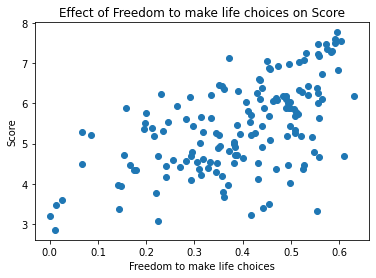

In [35]:
X = whr_2019_df['Freedom to make life choices']
Y = whr_2019_df['Score']
plt.scatter(X, Y)
plt.xlabel("Freedom to make life choices")
plt.ylabel("Score")
plt.title("Effect of Freedom to make life choices on Score")
plt.show()

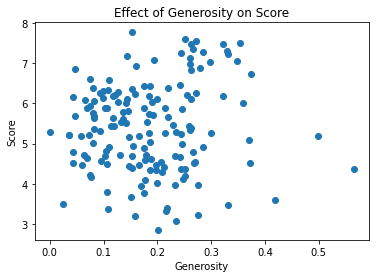

In [36]:
X = whr_2019_df['Generosity']
Y = whr_2019_df['Score']
plt.scatter(X, Y)
plt.xlabel("Generosity")
plt.ylabel("Score")
plt.title("Effect of Generosity on Score")
plt.show()

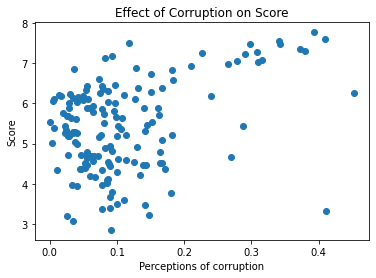

In [37]:
X = whr_2019_df['Perceptions of corruption']
Y = whr_2019_df['Score']
plt.scatter(X, Y)
plt.xlabel("Perceptions of corruption")
plt.ylabel("Score")
plt.title("Effect of Corruption on Score")
plt.show()

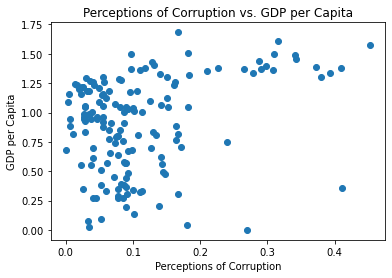

In [38]:
X = whr_2019_df['Perceptions of corruption']
Y = whr_2019_df['GDP per capita']
plt.scatter(X, Y)
plt.xlabel("Perceptions of Corruption")
plt.ylabel("GDP per Capita")
plt.title("Perceptions of Corruption vs. GDP per Capita")
plt.show()

In [45]:
whr2019df=whr_2019_df.drop('Country or region', axis=1)
whr2019df

Overall rank  Score  GDP per capita  Social support  \
0               1  7.769           1.340           1.587   
1               2  7.600           1.383           1.573   
2               3  7.554           1.488           1.582   
3               4  7.494           1.380           1.624   
4               5  7.488           1.396           1.522   
..            ...    ...             ...             ...   
151           152  3.334           0.359           0.711   
152           153  3.231           0.476           0.885   
153           154  3.203           0.350           0.517   
154           155  3.083           0.026           0.000   
155           156  2.853           0.306           0.575   

     Healthy life expectancy  Freedom to make life choices  Generosity  \
0                      0.986                         0.596       0.153   
1                      0.996                         0.592       0.252   
2                      1.028                         0.603       0.271   
3                      1.026                         0.591       0.354   
4                      0.999                         0.557       0.322   
..                       ...                           ...         ...   
151                    0.614                         0.555       0.217   
152                    0.499                         0.417       0.276   
153                    0.361                         0.000       0.158   
154                    0.105                         0.225       0.235   
155                    0.295                         0.010       0.202   

     Perceptions of corruption  
0                        0.393  
1                        0.410  
2                        0.341  
3                        0.118  
4                        0.298  
..                         ...  
151                      0.411  
152                      0.147  
153                      0.025  
154                      0.035  
155                      0.091  

[156 rows x 8 columns]

In [46]:
#separate the data to X and y
X = whr2019df.drop('Score', axis=1)
y = whr2019df['Score']
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler=StandardScaler()
kmeans = KMeans(n_clusters=3)
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(X)
labels = pipeline.predict(X)


ValueError: x and y must be the same size

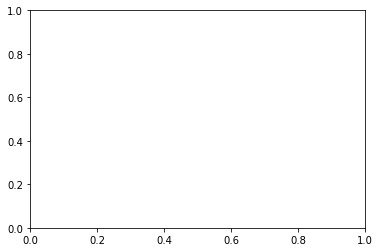

In [47]:
plt.scatter(X, y, c=labels)
plt.show()

In [48]:
from sklearn import metrics
from scipy.spatial.distance import cdist

inertias = []
distortions = []
for k in range(1,10):
    #build and fit the model
    model = KMeans(n_clusters=k).fit(X)
    
    #average of squared distance from cluster center to the data points
    distortion = sum(np.min(cdist(X, model.cluster_centers_,
                                  'euclidean'),axis =1))/X.shape[0]
    
    distortions.append(distortion)
    
    inertia = model.inertia_
    inertias.append(inertia)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'Elbow Method with Inertia')

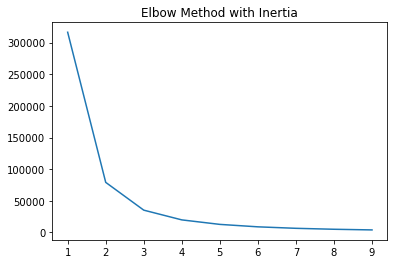

In [49]:
plt.plot(range(1,10),inertias)
plt.title('Elbow Method with Inertia')

Train: nan, Test: nan


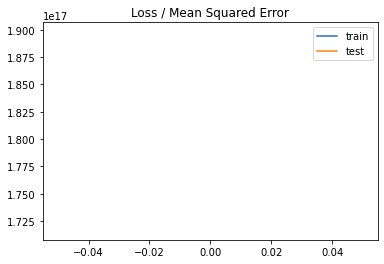

In [50]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

X = whr2019df.drop('Score', axis=1)
y = whr2019df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

scaler = StandardScaler()
scaler.fit_transform(X_train, y_train)

# define model
n_cols = X_train.shape[1]
input_shape = (n_cols,)

model = Sequential()
model.add(Dense(50, activation='relu',input_shape=input_shape))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
# compile model
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01, momentum=0.9))
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()